# The Timeseries Quantum Autoencoder - Selected Plots
*TS QAE in Qiskit with angle encoding of TS sliding windows*

By: Jacob Cybulski<br>
Date: August 2023 - February 2024<br>
Aims: The goal of this notebook is to plot the selected data from the results folder

In [1]:
%%html
<style>
table {float:left}
</style>

In [2]:
import sys
sys.path.append('.')
sys.path.append('..')
sys.path

['/home/jacob/Dropbox/Dev/Python/quantum_projects/ts/ts_denoise/qiskit_qae',
 '/home/jacob/miniconda3/envs/qiskit-gpu/lib/python310.zip',
 '/home/jacob/miniconda3/envs/qiskit-gpu/lib/python3.10',
 '/home/jacob/miniconda3/envs/qiskit-gpu/lib/python3.10/lib-dynload',
 '',
 '/home/jacob/miniconda3/envs/qiskit-gpu/lib/python3.10/site-packages',
 '.',
 '..']

In [98]:
import os
import pylab
import math
import json
import numpy as np

from IPython.display import clear_output

import matplotlib.pyplot as plt
%matplotlib inline

from utils.Target import *
from utils.Window import *
from utils.Callback import *
from utils.TS import *

from matplotlib import set_loglevel
set_loglevel("error")

## Settings

In [4]:
RESULTS_PATH = 'results'
FIGURES_PATH = 'figures'

## Utilities

In [5]:
# Exponential Moving Target used to smooth the lines 
def smooth_movtarg(scalars, weight):  # Weight between 0 and 1
    last = scalars[0]  # First value in the plot (first timestep)
    smoothed = list()
    for point in scalars:
        smoothed_val = last * weight + (1 - weight) * point  # Calculate smoothed value
        smoothed.append(smoothed_val)                        # Save it
        last = smoothed_val                                  # Anchor the last smoothed value        
    return smoothed

### Read JSON file
def read_json_file(fpath):
    data = []
    try:
        f = open(fpath, 'r')
    except OSError:
        print(f'Could not open/read file: {fpath}')
        sys.exit()
    with f:
        data = json.load(f)
    return data

## Windows integration

In [6]:
### Integrates QAE results stored in a single set of TS widows into a single sequence
#   Note: When windows overap their average values will be returned
#         When windows are too far apart, separate sub-sequences will be returned
#   wind_set: The selected set of TS windows
#   trim_left: The number of values to be trimmed from the left edge of each window
#   trim_right:  The number of values to be trimmed from the right edge of each window

def qae_winds_integ_1(wind_set, trim_left=0, trim_right=0):

    wind_set = {int(k):wind_set[k] for k in wind_set.keys()}

    # Collect all overalapping values into lists attached to individual data points
    vals = {}
    for k in sorted(wind_set.keys()):
        val_list = wind_set[k]
        list_len = len(val_list)
        for i in range(list_len):
            if (i < trim_left) or (i >= list_len - trim_right):
                None # Skip these trimmed values
            else:
                val_idx = k+i
                if val_idx in vals:
                    vals[val_idx].append(val_list[i])
                else:
                    vals[val_idx] = [val_list[i]]

    # Collapse all consecutive values into subsequences
    # All values apart start new subsequences
    seq = {}
    next_key = -3
    prev_key = 0
    for k in sorted(vals.keys()):
        next_key += 1
        if k == next_key:
            seq[prev_key].append(np.average(vals[k]))
        else:
            prev_key = k
            next_key = k
            seq[k] = [np.average(vals[k])]
            
    return seq


### Integrates QAE results stored as TS widows into a single sequence
#   Note: When windows overap their average values will be returned
#         When windows are too far apart, separate sub-sequences will be returned
#   in_org_set: The selected set of original TS windows
#   in_meas_set: The set of measurements of the original values in TS windows
#   out_recons_set: The set of QAE reconstructions for each original TS window
#   trim_left: The number of values to be trimmed from the left edge of each window
#   trim_right:  The number of values to be trimmed from the right edge of each window

def qae_winds_integ(in_org_set, in_meas_set, out_recons_set, trim_left=0, trim_right=0):
    in_org_seq = qae_winds_integ_1(in_org_set, trim_left, trim_right)
    in_meas_seq = qae_winds_integ_1(in_meas_set, trim_left, trim_right)
    out_recons_seq = qae_winds_integ_1(out_recons_set, trim_left, trim_right)
    return in_org_seq, in_meas_seq, out_recons_seq

### Test window integration
# in_org_seq, in_meas_seq, out_recons_seq = qae_winds_integ(in_org_set, in_meas_set, out_reconstr_set, trim_left, trim_right)
# [print((k, out_reconstr_set[k])) for k in sorted(out_reconstr_set.keys())]
# print()
# vals = qae_winds_integ_1(out_recons_seq)
# [print((k, vals[k])) for k in sorted(vals.keys())]

## Plotting functions

In [53]:
### Plot cost
def cost_plot(objective_func_vals, rcParams=(8, 4), yscale='linear', 
                  backplot=False, back_color='linen', smooth_weight=0.9, save_plot=None):
    min_cost = min(objective_func_vals)
    iter = len(objective_func_vals)
    smooth_fn = smooth_movtarg(objective_func_vals, smooth_weight)
    x_of_min = np.argmin(objective_func_vals)
    clear_output(wait=True)
    plt.rcParams["figure.figsize"] = rcParams
    plt.title(f'Cost vs iteration '+('with smoothing ' if smooth_weight>0 else ' ')+
              f'(iter# {iter}, min cost={np.round(min_cost, 4)})')
    plt.xlabel(f'Iteration (min cost @ iter# {x_of_min})')
    plt.ylabel("Cost function value")
    plt.axvline(x=x_of_min, color="lightgray", linestyle='--')
    plt.yscale(yscale)
    if backplot:
        plt.plot(range(len(objective_func_vals)), objective_func_vals, color=back_color) # lightgray
    plt.plot(smooth_fn, color='black')
    if save_plot is not None:
        plt.savefig(save_plot, format='eps')
    plt.show()

### Plot MAE
def mae_plot(mae_train_vals, mae_valid_vals, rcParams=(8, 4), yscale='linear', 
                  backplot=False, back_color='linen', smooth_weight=0.9, save_plot=None):
    # clear_output(wait=True)
    min_train_mae = min(mae_train_vals)
    min_valid_mae = min(mae_valid_vals)
    smooth_train = smooth_movtarg(mae_train_vals, smooth_weight)
    smooth_valid = smooth_movtarg(mae_valid_vals, smooth_weight)
    x_of_min = np.argmin(mae_valid_vals)
    iter = len(mae_train_vals)
    plt.rcParams["figure.figsize"] = rcParams
    plt.title(f'MAE vs iteration '+('with smoothing ' if smooth_weight>0 else ' ')+
              f'(iter# {iter}, '+
              f'min train MAE={np.round(min_train_mae, 4)}, '+
              f'valid MAE={np.round(min_valid_mae, 4)})')
    plt.xlabel(f'Iteration (min valid MAE @ iter# {x_of_min})')
    plt.ylabel("MAE")
    plt.axvline(x=x_of_min, color="lightgray", linestyle='--')
    plt.yscale(yscale)
    if backplot:
        plt.plot(range(len(mae_train_vals)), mae_train_vals, color=back_color) # powderblue
        plt.plot(range(len(mae_valid_vals)), mae_valid_vals, color=back_color) # mistyrose
    plt.plot(smooth_train, label='Training', color='blue')
    plt.plot(smooth_valid, label='Validation', color='red')
    plt.legend(loc='upper right', ncol=1)
    if save_plot is not None:
        plt.savefig(save_plot, format='eps')
    plt.show()

### Plot and compare various performance plots
def multi_perform_plot(pvals, rcParams=(8, 4), yscale='linear', 
                  backplot=False, smooth_weight=0.9, save_plot=None,
                  title='Performance vs iteration', meas_type='Cost', 
                  meas_min=True, labels=[], back_color='linen',
                  bbox_pos=(0.5, -0.35)):
    if not pvals: # Empty list of curves
        return
    iter = max([len(p) for p in pvals])
    plt.rcParams["figure.figsize"] = rcParams
    plt.title(f'{title} '+('with smoothing ' if smooth_weight>0 else ' ')+
              f'(iter# {iter})')
    plt.xlabel(f'Iteration')
    plt.ylabel(meas_type)
    plt.yscale(yscale)
    for i in range(len(pvals)):
        if backplot:
            plt.plot(range(len(pvals[i])), pvals[i], color=back_color)
    for i in range(len(pvals)):
        if meas_min:
            lim = 'min'
            sel_val = np.round(min(pvals[i]), 3)
            sel_x = np.argmin(pvals[i])
        else:
            lim = 'max'
            sel_val = np.round(max(pvals[i]), 3)
            sel_x = np.argmax(pvals[i])
        smooth_vals = smooth_movtarg(pvals[i], smooth_weight)
        sel_lab = labels[i] if labels else f'{i}'
        plt.plot(range(len(pvals[i])), smooth_vals, label=f'{sel_lab}  ({lim} {meas_type}={sel_val} @ iter# {sel_x})')
    plt.legend(loc='upper right', ncol=1)
    if save_plot is not None:
        plt.savefig(save_plot, format='eps')
    plt.show()


### Plot all the selected windows and their recovered data
def qae_plot_winds(in_org_set, in_meas_set, out_reconstr_set, plot_no=None, ylim=None, save_plot=None, 
                   title='Original and measured input vs reconstructed data', xlabel="Data points", ylabel="Inter-point differences"):
    
    sorted_keys = sorted(in_org_set.keys())
    if plot_no == None:
        plot_no = len(sorted_keys)
        
    for sel_wind in sorted_keys:

        if plot_no == 0:
            break
    
        # Retrieve window data
        print('\n')
        wind = in_org_set[sel_wind]
        org_meas = in_meas_set[sel_wind]
        out_meas = out_reconstr_set[sel_wind]    
        
        # Plot prepared data
        plt.rcParams["figure.figsize"] = (12, 6)
        plt.title(f'{title}, within window {sel_wind}')
        plt.xlabel(xlabel)
        plt.ylabel(ylabel)
        if ylim is not None:
            plt.ylim(ylim[0], ylim[1])
        
        # Plot target function
        plt.plot([x for x in range(len(wind))], wind, color='royalblue', label='Original data')
        plt.plot([x for x in range(len(wind))], wind, marker='o', color='cornflowerblue', linestyle='None')
        plt.plot([x for x in range(len(wind))], org_meas, color='darkorange', label='Measured noisy input')
        plt.plot([x for x in range(len(wind))], org_meas, marker='o', color='orange', linestyle='None')
        plt.plot([x for x in range(len(wind))], out_meas, color='red', label='Reconstructed data')
        plt.plot([x for x in range(len(wind))], out_meas, marker='o', color='tomato', linestyle='None')
        plt.legend(loc='best', ncol=3)
        if save_plot is not None:
            plt.savefig(f'{save_plot}_wind{sel_wind}.eps', format='eps')
        plt.show()

        plot_no -= 1
        
    print('\n')

### Plot integrated windows

In [8]:
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

### Returns the x range for the sequence set
def qae_seq_x_range(start, subseq):
    return range(start, start+len(subseq))

### Plots all three sequences (may consist of separate subsets)
def qae_seq_plot(in_org_seq, in_meas_seq, out_recons_seq, 
                 add_markers=False, save_plot=None,
                 label_suffix=['', '', ''], ylim=(-0.5, 0.5),
                 xlabel='Selected data points', ylabel='Inter-point differences',
                 title=f'Original and measured input vs reconstructed data'):
    
    sorted_keys = sorted(in_org_seq.keys())
    
    # Plot prepared data
    plt.rcParams["figure.figsize"] = (12, 6)
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.ylim(ylim[0], ylim[1])
        
    for sel_wind in sorted_keys:

        org_in = in_org_seq[sel_wind]
        org_meas = in_meas_seq[sel_wind]
        out_meas = out_recons_seq[sel_wind]    
        
        # Plot target function
        plt.plot(qae_seq_x_range(sel_wind, org_in), org_in, color='royalblue')
        if add_markers:
            plt.plot(qae_seq_x_range(sel_wind, org_in), org_in, marker='o', color='cornflowerblue', linestyle='None')
        plt.plot(qae_seq_x_range(sel_wind, org_meas), org_meas, color='darkorange')
        if add_markers:
            plt.plot(qae_seq_x_range(sel_wind, org_meas), org_meas, marker='o', color='orange', linestyle='None')
        plt.plot(qae_seq_x_range(sel_wind, out_meas), out_meas, color='red')
        if add_markers:
            plt.plot(qae_seq_x_range(sel_wind, out_meas), out_meas, marker='o', color='tomato', linestyle='None')
        
    # access legend objects automatically created from data
    handles, labels = plt.gca().get_legend_handles_labels()
    
    # create manual symbols for legend
    line_org = Line2D([0], [0], label=f'Original data {label_suffix[0]}', color='royalblue')
    line_meas = Line2D([0], [0], label=f'Measured data {label_suffix[1]}', color='darkorange')
    line_recon = Line2D([0], [0], label=f'Reconstructed data {label_suffix[2]}', color='red')
    
    # add manual symbols to auto legend
    handles.extend([line_org, line_meas, line_recon])
    
    # plt.legend(handles=handles)    
    plt.legend(handles=handles, loc='lower center', bbox_to_anchor=(0.5, -0.2),
               ncol=3, fancybox=True, shadow=True)
    if save_plot is not None:
        plt.savefig(save_plot, format='eps')
    plt.show()

    print('\n')
    return


## Sample plots

### Cost and MAE plots
Full-QAE larger beer data set lat=5, trash=3

In [9]:
# Load data
hist = read_json_file(f'{RESULTS_PATH}/qae_wangle_lat5_tr3_reps2_sca_p48_err0.03_zeroes_hist500_large.json')
tmae = read_json_file(f'{RESULTS_PATH}/qae_wangle_lat5_tr3_reps2_sca_p48_err0.03_zeroes_tmae500_large.json')
vmae = read_json_file(f'{RESULTS_PATH}/qae_wangle_lat5_tr3_reps2_sca_p48_err0.03_zeroes_vmae500_large.json')

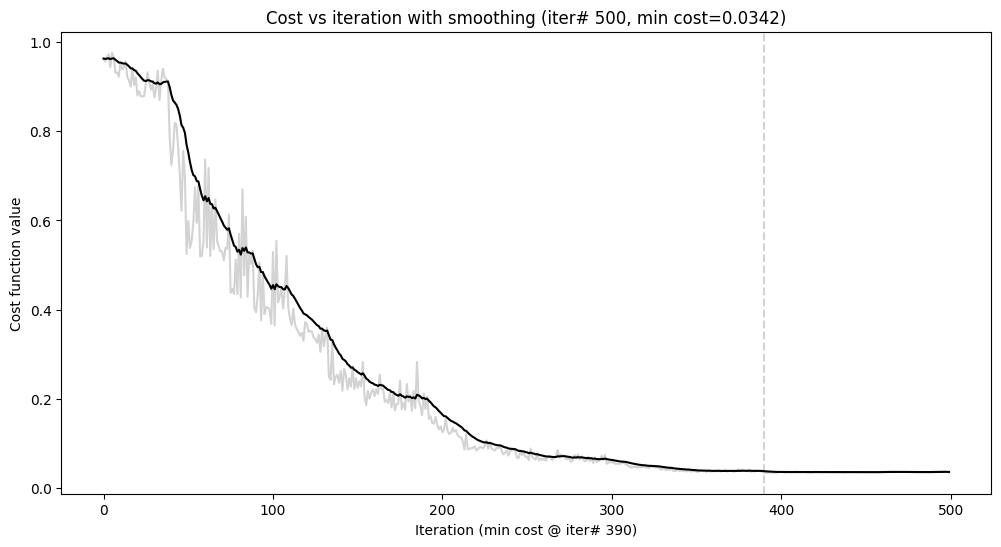

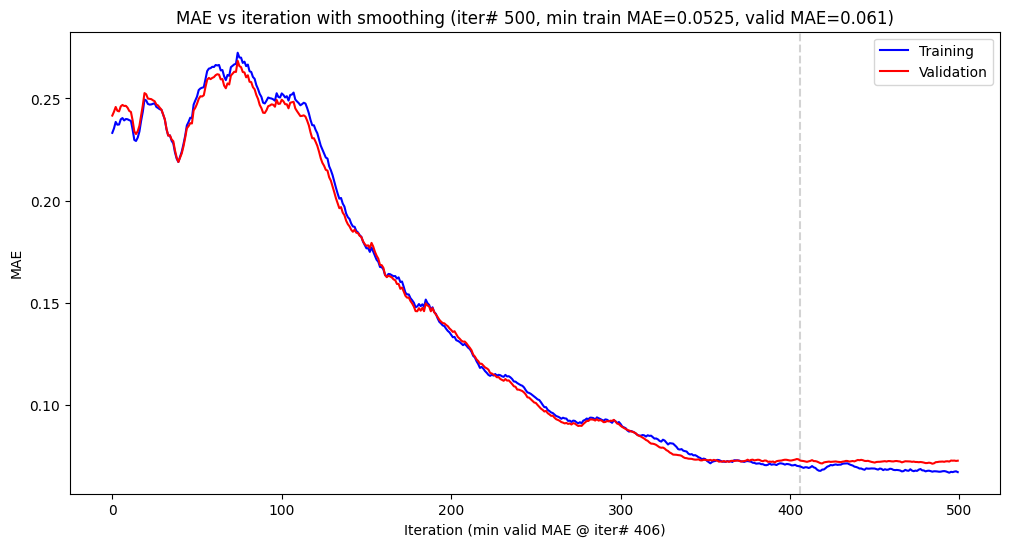

In [97]:
print()
cost_plot(hist, rcParams=(12, 6), smooth_weight=0.9, backplot=True, 
          save_plot=f'{FIGURES_PATH}/train_perform_cost.eps', back_color='lightgray') # linen aliceblue powderblue paleturquoise whitesmoke lightgray antiquewhite lightsteelblue
print()
mae_plot(tmae, vmae, rcParams=(12, 6), smooth_weight=0.95, backplot=False, 
         save_plot=f'{FIGURES_PATH}/train_perform_mae.eps', back_color='lightgray')
print()

### Comparison of performance for models of different size

In [88]:
# Load data
hist1 = read_json_file(f'{RESULTS_PATH}/qae_wangle_lat5_tr3_reps1_sca_p32_err0.03_zeroes_hist500.json')
hist2 = read_json_file(f'{RESULTS_PATH}/qae_wangle_lat5_tr3_reps2_sca_p48_err0.03_zeroes_hist500.json')
hist3 = read_json_file(f'{RESULTS_PATH}/qae_wangle_lat5_tr3_reps3_sca_p64_err0.03_zeroes_hist_1000.json')
hist4 = read_json_file(f'{RESULTS_PATH}/qae_wangle_lat5_tr3_reps4_sca_p80_err0.03_zeroes_hist_1000.json')
hist_data = [hist1, hist2, hist3, hist4]
labels = ['reps=1', 'reps=2', 'reps=3', 'reps=4']

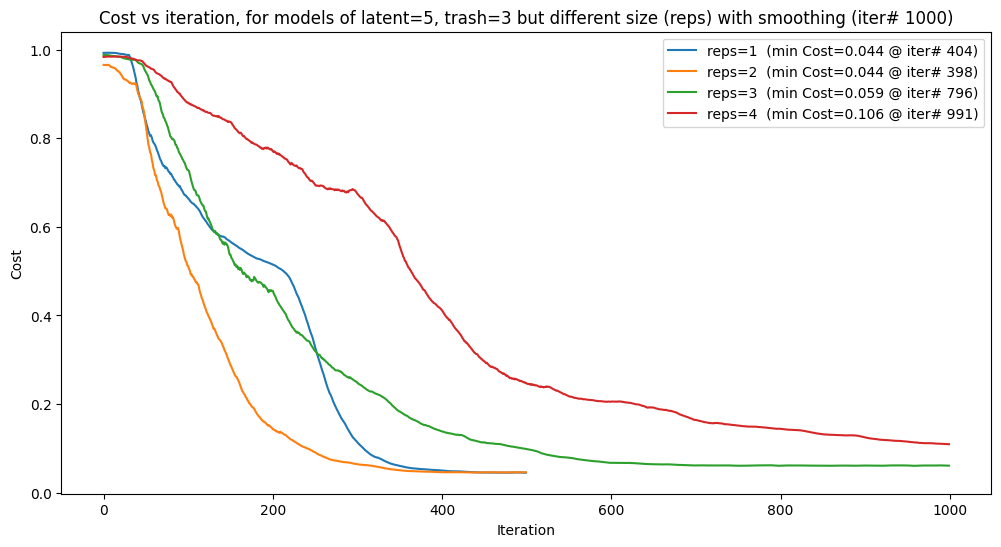

In [90]:
multi_perform_plot(hist_data, rcParams=(12, 6), yscale='linear', # yscale='log'
                  backplot=False, smooth_weight=0.95, save_plot=f'{FIGURES_PATH}/train_perform_cost_reps1_4.eps',
                  title='Cost vs iteration, for models of latent=5, trash=3 but different size (reps)', meas_type='Cost', 
                  meas_min=True, labels=labels, back_color='lightgray') # 'linen' 'aliceblue' 'powderblue' 'paleturquoise' 'whitesmoke' 'lightgray' 'antiquewhite'

### Comparison of training performance
Full QAE version 3.0, small beer data with varying latent space in the range [1..8]

In [43]:
reps=2
ent='sca'
num_qubits = 8
num_trash = 3
params = 48
epochs = 500 
noise = 0.03

In [83]:
import pathlib
path = pathlib.Path(f'{RESULTS_PATH}')

hist_files = []
labels = []
for tr in range(0, 8):
    pattern = f'qae_wangle_lat{num_qubits-tr}_tr{tr}_reps{reps}_{ent}_p{params}_err{noise}*hist{epochs}.json'
    fn = list(path.glob(pattern))[0]
    hist_files.append(f'{RESULTS_PATH}/{fn.name}')
    labels.append(f'latent={num_qubits-tr} trash={tr}')
print(labels)
hist_files

['latent=8 trash=0', 'latent=7 trash=1', 'latent=6 trash=2', 'latent=5 trash=3', 'latent=4 trash=4', 'latent=3 trash=5', 'latent=2 trash=6', 'latent=1 trash=7']


['results/qae_wangle_lat8_tr0_reps2_sca_p48_err0.03_zeroes_hist500.json',
 'results/qae_wangle_lat7_tr1_reps2_sca_p48_err0.03_zeroes_hist500.json',
 'results/qae_wangle_lat6_tr2_reps2_sca_p48_err0.03_zeroes_hist500.json',
 'results/qae_wangle_lat5_tr3_reps2_sca_p48_err0.03_zeroes_hist500.json',
 'results/qae_wangle_lat4_tr4_reps2_sca_p48_err0.03_zeroes_hist500.json',
 'results/qae_wangle_lat3_tr5_reps2_sca_p48_err0.03_zeroes_hist500.json',
 'results/qae_wangle_lat2_tr6_reps2_sca_p48_err0.03_zeroes_hist500.json',
 'results/qae_wangle_lat1_tr7_reps2_sca_p48_err0.03_zeroes_hist500.json']

In [84]:
hist_data = []
for hf in hist_files:
    hist_data.append(read_json_file(hf))

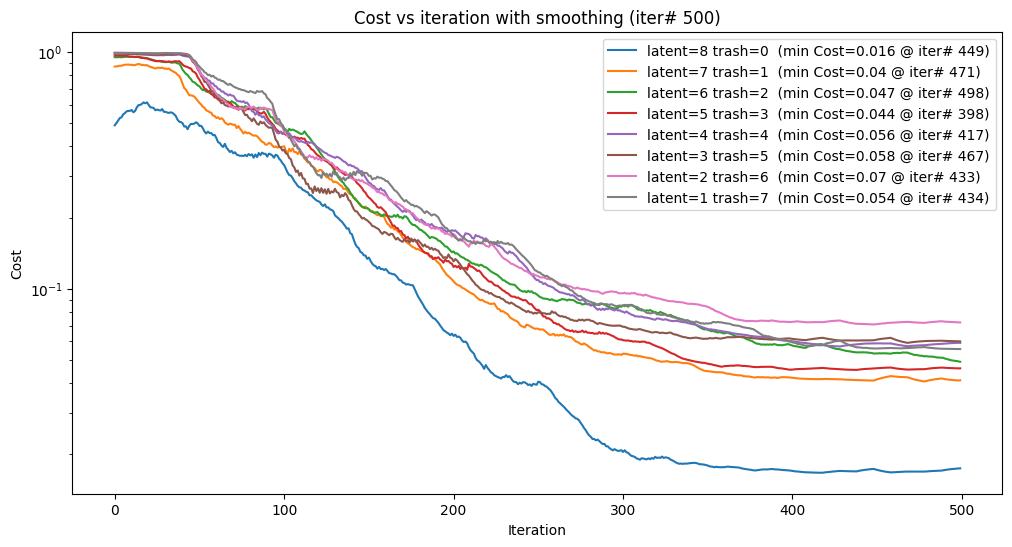

In [87]:
multi_perform_plot(hist_data, rcParams=(12, 6), yscale='log', # yscale='log'
                  backplot=False, smooth_weight=0.9, save_plot=f'{FIGURES_PATH}/train_perform_cost_lat1_8.eps',
                  title='Cost vs iteration', meas_type='Cost', 
                  meas_min=True, labels=labels, back_color='lightgray') # 'aliceblue' 'powderblue' 'paleturquoise' 'whitesmoke' 'lightgray' 'antiquewhite'

### Plot the selected validation windows
Full-QAE version 3.0, best from above latent=5, trash=3

In [35]:
reps=4
ent='sca'
num_qubits = 8
num_trash = 3
num_latent = num_qubits-num_trash
cost_type = 'zeroes' # min1s, swap, zeroes
cost_yscale = 'linear' # linear, log
params = 80
epochs = 500 
noise = 0.03
shots=10000

In [36]:
import pathlib
path = pathlib.Path(f'{RESULTS_PATH}')

pattern = f'qae_wangle_lat{num_latent}_tr{num_trash}_reps{reps}_{ent}_p{params}_err{noise}_{cost_type}_[io][nru][mgt].json'
fdir_match = path.glob(pattern)
fnames = list(sorted(fdir_match))
fnames

[PosixPath('results/qae_wangle_lat5_tr3_reps4_sca_p80_err0.03_zeroes_inm.json'),
 PosixPath('results/qae_wangle_lat5_tr3_reps4_sca_p80_err0.03_zeroes_org.json'),
 PosixPath('results/qae_wangle_lat5_tr3_reps4_sca_p80_err0.03_zeroes_out.json')]

In [37]:
# Load data
in_meas = read_json_file(f'{RESULTS_PATH}/{fnames[0].name}')
in_org = read_json_file(f'{RESULTS_PATH}/{fnames[1].name}')
out_recons = read_json_file(f'{RESULTS_PATH}/{fnames[2].name}')

In [38]:
print(len(in_org), len(in_meas), len(out_recons))

10 10 10


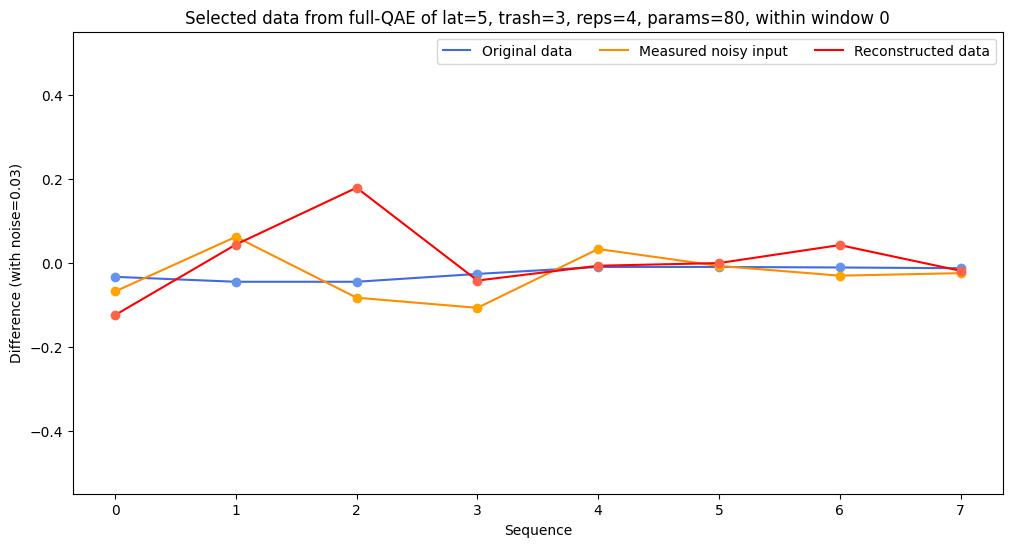

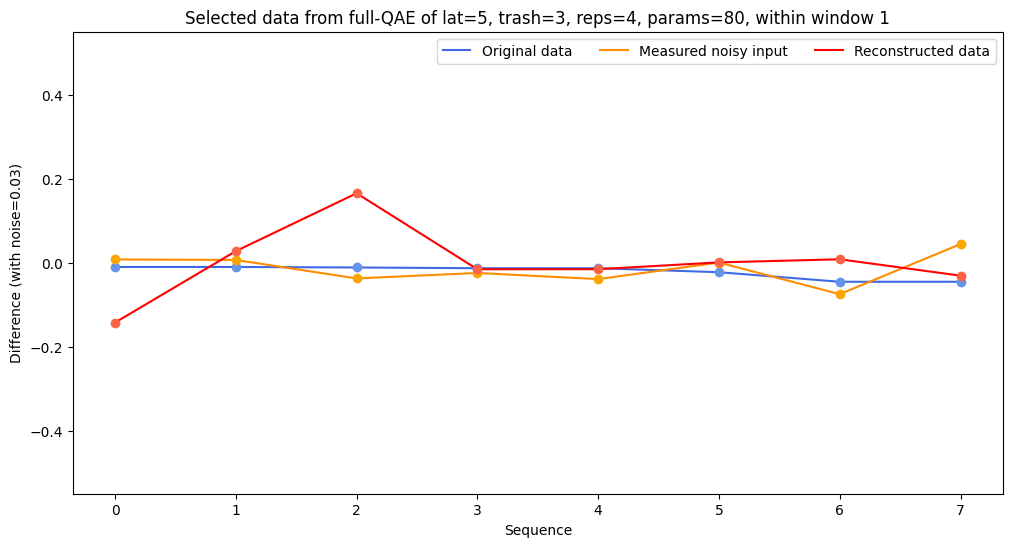

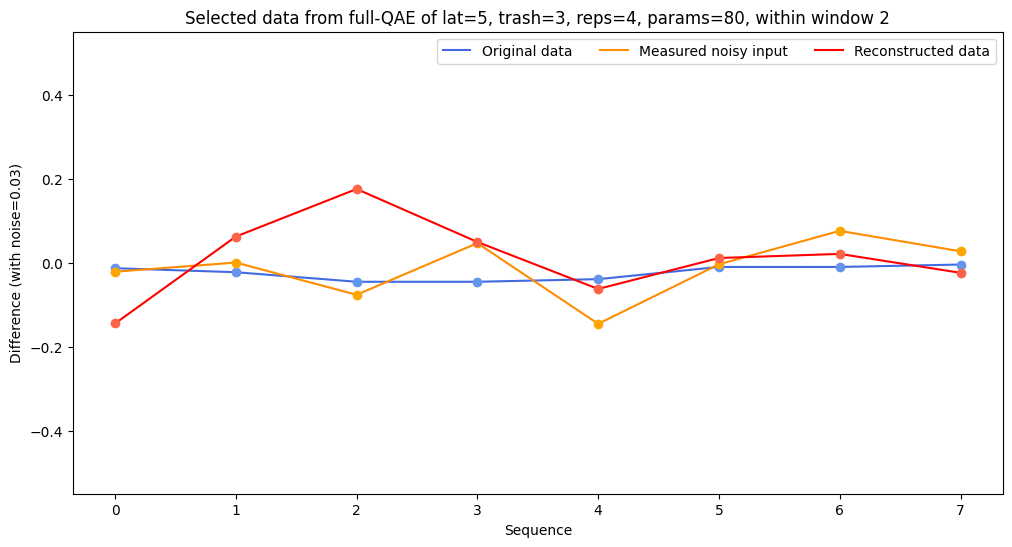

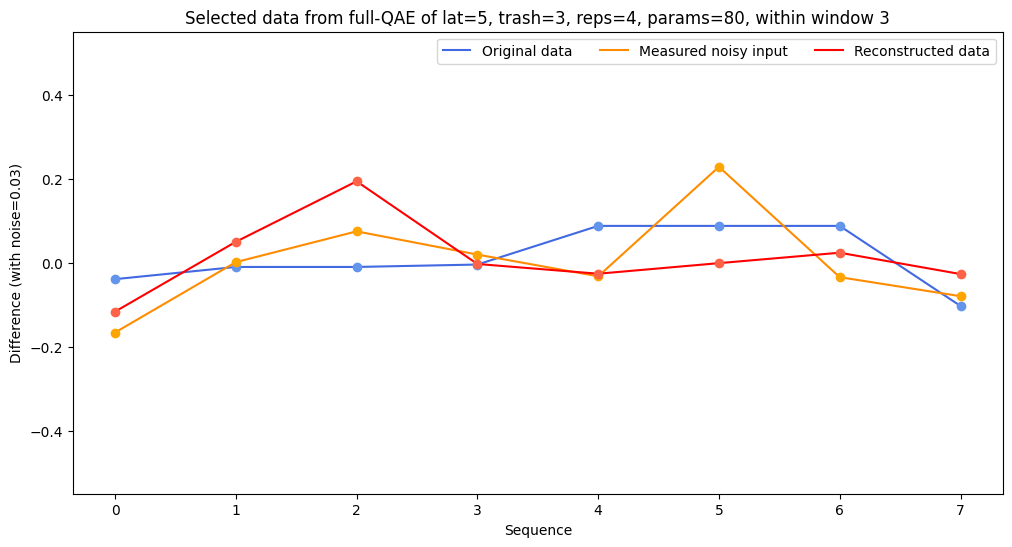

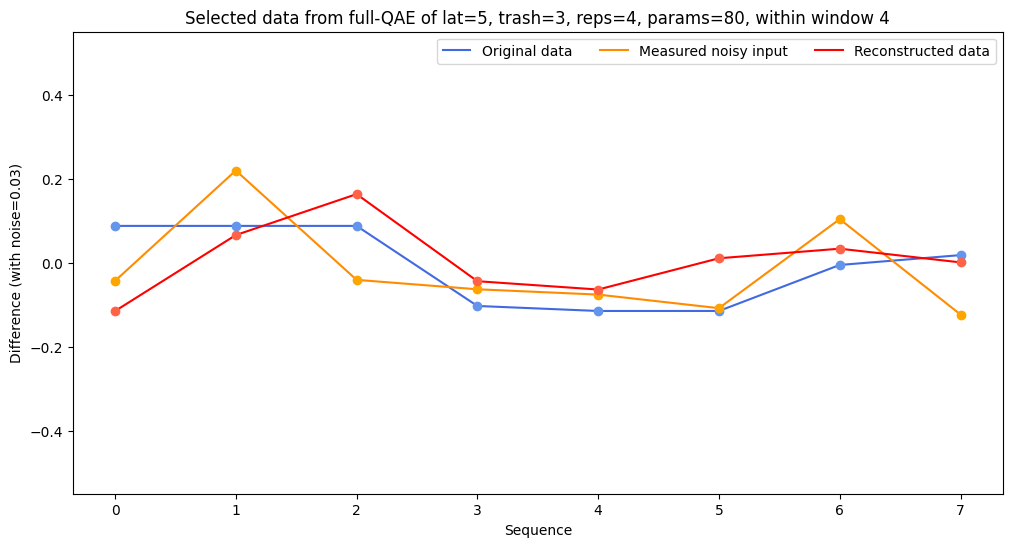

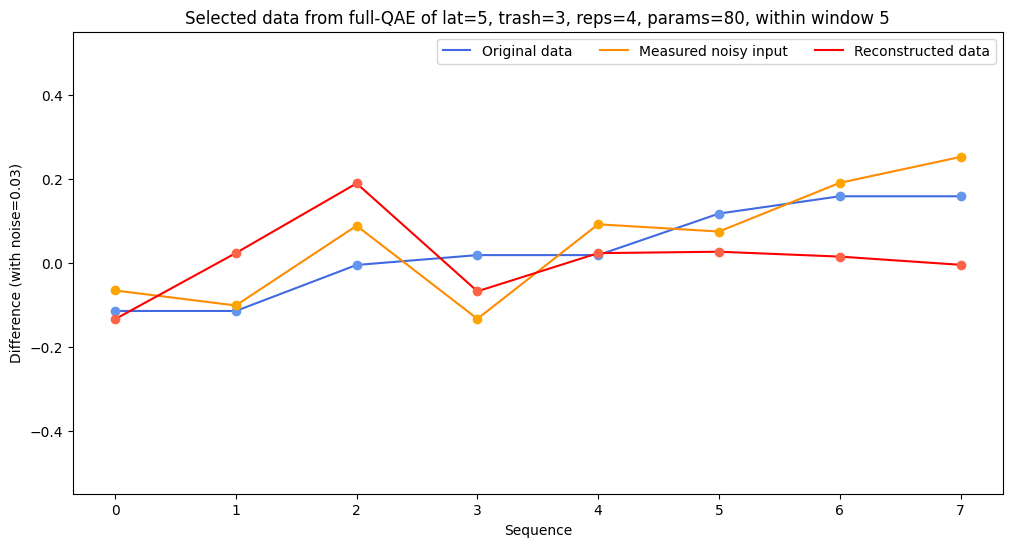

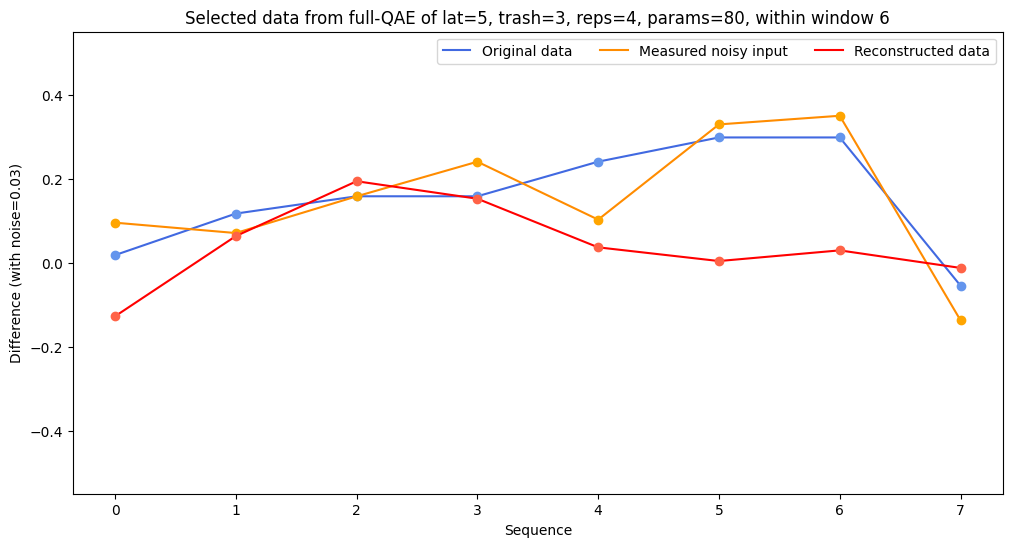

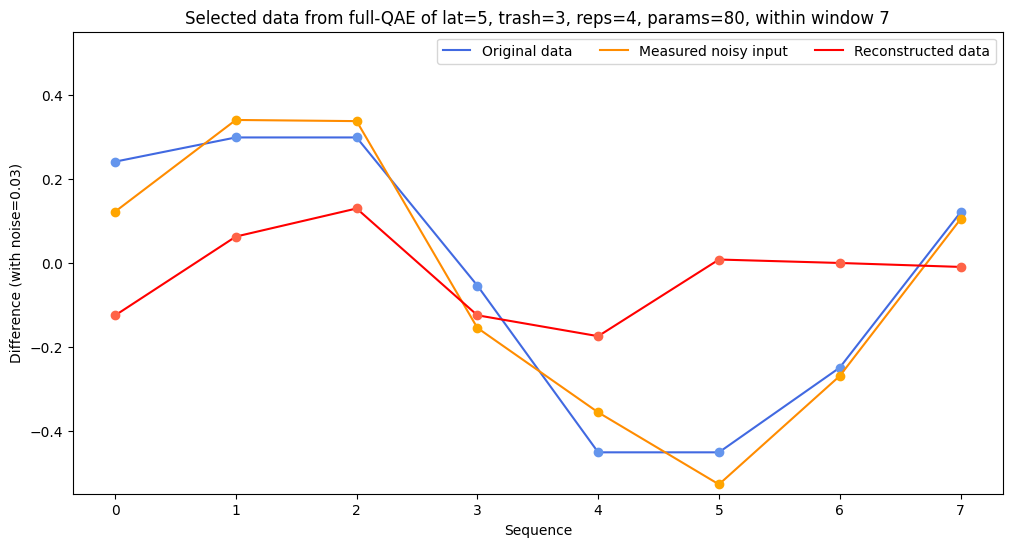

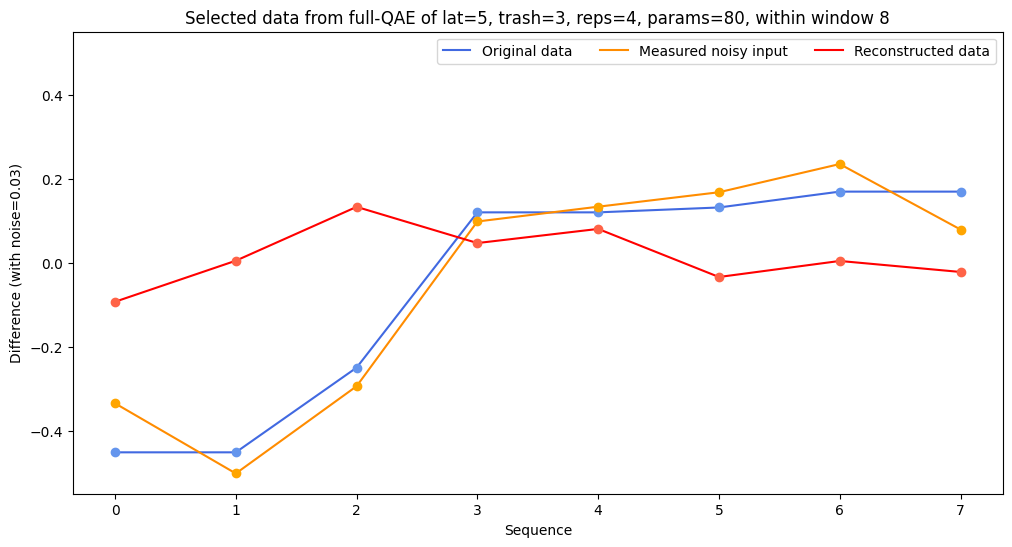

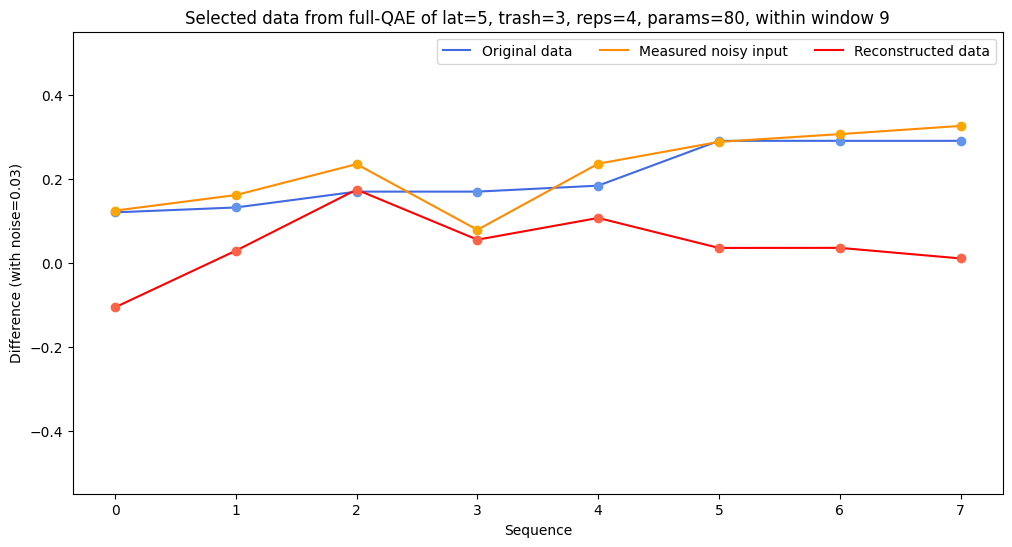

In [39]:
qae_plot_winds(in_org, in_meas, out_recons, plot_no=len(in_meas), ylim=(-0.55, 0.55), 
               xlabel='Sequence', ylabel=f'Difference (with noise={noise})', 
               title=f'Selected data from full-QAE of lat={num_latent}, trash={num_trash}, reps={reps}, params={params}',
               save_plot=f'{FIGURES_PATH}/ts_fit_lat{num_latent}_tr{num_trash}_reps{reps}_params{params}'
               )

### Plot of integrated validation windows

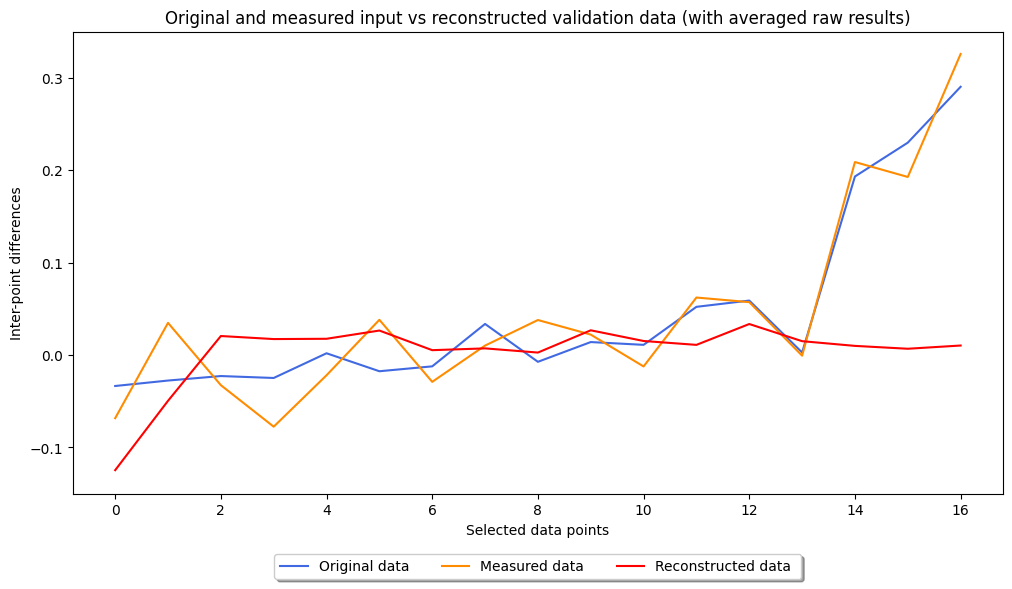

In [40]:
# Plot all raw results
in_org_train_seq, in_meas_train_seq, out_recons_train_seq = qae_winds_integ(in_org, in_meas, out_recons)
qae_seq_plot(in_org_train_seq, in_meas_train_seq, out_recons_train_seq, ylim=(-0.15, 0.35),
             title=f'Original and measured input vs reconstructed validation data (with averaged raw results)',
             save_plot=f'{FIGURES_PATH}/ts_fit_lat{num_latent}_tr{num_trash}_reps{reps}_params{params}_valid_integr.eps')

## Software in use

In [27]:
!pip list | grep -E 'qiskit|torch'

qiskit                        0.45.2
qiskit-aer-gpu                0.13.2
qiskit-algorithms             0.2.2
qiskit-dynamics               0.4.3
qiskit-finance                0.4.0
qiskit-ibm-provider           0.6.3
qiskit-ibm-runtime            0.11.3
qiskit-ibmq-provider          0.20.2
qiskit-machine-learning       0.7.1
qiskit-nature                 0.7.1
qiskit-optimization           0.6.0
qiskit-qasm3-import           0.4.1
qiskit-sphinx-theme           1.12.1
qiskit-terra                  0.45.2
torch                         2.1.0
torchaudio                    2.1.0
torchsummary                  1.5.1
torchvision                   0.16.0
